In [2]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import SpectralEmbedding
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook

In [3]:
# Read in the basketball-reference dataframe
df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Basketball-reference data\df_with_all_positions(2001-2024).csv")
df.set_index(['Season', 'Player'], inplace=True)

In [4]:
df

Pos   G    MP   FTr  USG% % of FGA by Distance - 2P  \
Season Player                                                                
2001   A.C. Green       PF  82  1411  .343  14.4                      .981   
       A.J. Guyton      PG  33   630  .094  16.5                      .641   
       Aaron McKie      SG  76  2394  .272  18.9                      .762   
       Aaron Williams   PF  82  2336  .477  17.8                      .997   
       Adam Keefe       PF  67   836  .396  11.5                      .981   
...                     ..  ..   ...   ...   ...                       ...   
2024   Zach LaVine      SG  25   872  .274  23.8                      .551   
       Zavier Simpson   PG   7   161  .074  17.5                      .685   
       Zeke Nnaji       PF  58   576  .416  15.4                      .846   
       Ziaire Williams  SF  51  1038  .198  19.7                      .500   
       Zion Williamson  PF  70  2207  .452  29.7                      .984   

                       % of FGA by Distance - 0-3 % of FGA by Distance - 3-10  \
Season Player                                                                   
2001   A.C. Green                            .278                        .102   
       A.J. Guyton                           .078                        .042   
       Aaron McKie                           .232                        .137   
       Aaron Williams                        .502                        .262   
       Adam Keefe                            .377                        .176   
...                                           ...                         ...   
2024   Zach LaVine                           .237                        .136   
       Zavier Simpson                        .167                        .333   
       Zeke Nnaji                            .597                        .215   
       Ziaire Williams                       .220                        .127   
       Zion Williamson                       .547                        .404   

                       % of FGA by Distance - 10-16  \
Season Player                                         
2001   A.C. Green                              .164   
       A.J. Guyton                             .094   
       Aaron McKie                             .183   
       Aaron Williams                          .131   
       Adam Keefe                              .170   
...                                             ...   
2024   Zach LaVine                             .053   
       Zavier Simpson                          .093   
       Zeke Nnaji                              .027   
       Ziaire Williams                         .085   
       Zion Williamson                         .030   

                       % of FGA by Distance - 16-3P  ...  STL  BLK  TOV   PF  \
Season Player                                        ...                       
2001   A.C. Green                              .438  ...  0.4  0.1  0.5  1.5   
       A.J. Guyton                             .427  ...  0.3  0.2  0.7  1.1   
       Aaron McKie                             .209  ...  1.4  0.1  2.7  2.3   
       Aaron Williams                          .103  ...  0.7  1.4  1.6  3.9   
       Adam Keefe                              .258  ...  0.4  0.3  0.6  1.5   
...                                             ...  ...  ...  ...  ...  ...   
2024   Zach LaVine                             .125  ...  0.8  0.3  2.1  2.3   
       Zavier Simpson                          .093  ...  1.0  0.4  1.4  1.6   
       Zeke Nnaji                              .007  ...  0.3  0.7  0.5  1.4   
       Ziaire Williams                         .069  ...  0.7  0.2  1.3  1.7   
       Zion Williamson                         .003  ...  1.1  0.7  2.8  2.3   

                       Position Estimate - PG% Position Estimate - SG%  \
Season Player                                                            
2001   A.C. Green                            0   

In [4]:
# Cleaning up the dataframe
df.rename(columns = {'PF': 'Personal Fouls Committed'}, inplace=True)
df.rename(columns = {'Fouls Drawn - Shoot': 'Shooting Fouls Drawn'}, inplace=True)
df.drop(columns = ['% of FGA by Distance - 2P', 'FG'], inplace=True)

# Removing any players named "Player"
df.reset_index(inplace=True)
df = df[df['Player'] != 'Player']
df.set_index(['Season', 'Player'], inplace=True)

In [5]:
positions = ['PG', 'SG', 'SF', 'PF', 'C']
dfs_by_position = {}
for position in positions:
    dfs_by_position[position] = df[df['Pos'] == position]
    dfs_by_position[position] = dfs_by_position[position].drop(columns=['Pos'])

In [6]:
for df in dfs_by_position:
    # Changing all the values in the df to be floats so that I can apply PCA
    dfs_by_position[df].fillna(0, inplace=True)  # Filling NaNs with 0
    dfs_by_position[df] = dfs_by_position[df].astype(float)

    # Replacing any infinite values with 0
    dfs_by_position[df].replace([np.inf, -np.inf], 0, inplace=True)

    per_48_stats = ['FGA', 'Personal Fouls Committed', 'BLK', 'STL', 'DRB', 'ORB', 'TOV', 'AST']

    for stat in per_48_stats:
        dfs_by_position[df][stat] = dfs_by_position[df][stat] / (dfs_by_position[df]['MP'] / dfs_by_position[df]['G']) * 48

    ordered_cols = ['G', 'MP', 'USG%', 'FGA', 'Personal Fouls Committed', 'BLK', 'STL', 'DRB', 'ORB', 'TOV', 'AST', "% of FG Ast'd - 3P", "% of FG Ast'd - 2P", 'FTr', 'Shooting Fouls Drawn', 'Corner 3s - %3PA', '% of FGA by Distance - 3P', '% of FGA by Distance - 16-3P', '% of FGA by Distance - 10-16', '% of FGA by Distance - 3-10', '% of FGA by Distance - 0-3', 'Dunks - %FGA', ]
    dfs_by_position[df] = dfs_by_position[df].reindex(columns = ordered_cols)

In [7]:
dfs_by_position['PF']

G      MP  USG%        FGA  \
Season Player                                              
2001   A.C. Green          82.0  1411.0  14.4  11.158044   
       Aaron Williams      82.0  2336.0  17.8  13.310959   
       Adam Keefe          67.0   836.0  11.5   9.232536   
       Al Harrington       78.0  1892.0  18.8  13.852008   
       Alan Henderson      73.0  1810.0  22.6  17.810387   
...                         ...     ...   ...        ...   
2024   Usman Garuba         6.0    18.0  20.8  16.000000   
       Wenyen Gabriel       5.0    81.0  17.0  13.037037   
       Xavier Tillman Sr.  54.0   974.0  14.8  13.838193   
       Zeke Nnaji          58.0   576.0  15.4  12.566667   
       Zion Williamson     70.0  2207.0  29.7  23.749887   

                           Personal Fouls Committed       BLK       STL  \
Season Player                                                             
2001   A.C. Green                          4.184266  0.278951  1.115804   
       Aaron Williams                      6.571233  2.358904  1.179452   
       Adam Keefe                          5.770335  1.154067  1.538756   
       Al Harrington                       5.738689  0.395772  1.583087   
       Alan Henderson                      4.259006  0.774365  1.355138   
...                                             ...       ...       ...   
2024   Usman Garuba                        4.800000  8.000000  3.200000   
       Wenyen Gabriel                      5.925926  1.185185  1.185185   
       Xavier Tillman Sr.                  3.725667  2.128953  2.395072   
       Zeke Nnaji                          6.766667  3.383333  1.450000   
       Zion Williamson                     3.501586  1.065700  1.674671   

                                 DRB       ORB       TOV  ...  \
Season Player                                             ...   
2001   A.C. Green           6.973777  3.626364  1.394755  ...   
       Aaron Williams       7.750685  4.380822  2.695890  ...   
       Adam Keefe           6.924402  5.000957  2.308134  ...   
       Al Harrington        6.728118  2.968288  3.759831  ...   
       Alan Henderson       6.001326  4.839779  3.291050  ...   
...                              ...       ...       ...  ...   
2024   Usman Garuba        11.200000  8.000000  4.800000  ...   
       Wenyen Gabriel      10.666667  4.148148  4.740741  ...   
       Xavier Tillman Sr.   6.919097  3.459548  1.596715  ...   
       Zeke Nnaji           5.316667  5.316667  2.416667  ...   
       Zion Williamson      6.241957  2.588129  4.262800  ...   

                           % of FG Ast'd - 2P    FTr  Shooting Fouls Drawn  \
Season Player                                                                
2001   A.C. Green                       0.764  0.343                   NaN   
       Aaron Williams                   0.623  0.477                   NaN   
       Adam Keefe                       0.683  0.396                   NaN   
       Al Harrington                    0.675  0.289                   NaN   
       Alan Henderson                   0.537  0.404                   NaN   
...                                       ...    ...                   ...   
2024   Usman Garuba                     0.000  0.333                   NaN   
       Wenyen Gabriel                   0.714  0.227                   NaN   
       Xavier Tillman Sr.               0.812  0.179                   NaN   
       Zeke Nnaji                       0.619  0.416                   NaN   
       Zion Williamson                  0.474  0.452                   NaN   

                           Corner 3s - %3PA  % of FGA by Distance - 3P  \
Season Player                                                            
2001   A.C. Green                     0.167                      0.019   
       Aaron Williams                 0.000                      0.003   
       Adam Keefe                     0.333                      0.019   
       Al Harrington                  0.14

In [8]:
for df in dfs_by_position:
    # Filter out players who played less than 20 games or 10 min/game in a season
    dfs_by_position[df] = dfs_by_position[df][(dfs_by_position[df]['G'] >= 20) & ((dfs_by_position[df]['MP'] / dfs_by_position[df]['G']) >= 10)]

    # Drop the G and MP columns as well as the Shooting Fouls column
    dfs_by_position[df] = dfs_by_position[df].drop(columns = ['G', 'MP', 'Shooting Fouls Drawn'])

In [9]:
pg_df = dfs_by_position['PG']
sg_df = dfs_by_position['SG']
sf_df = dfs_by_position['SF']
pf_df = dfs_by_position['PF']
c_df = dfs_by_position['C']

In [ ]:
pg_df.name = 'Point Guards'
sg_df.name = 'Shooting Guards'
sf_df.name = 'Small Forwards'
pf_df.name = 'Power Forwards'
c_df.name = "Centers"

In [ ]:
all_dfs = [pg_df, sg_df, sf_df, pf_df, c_df]
for df in all_dfs:
    df.drop(columns = ['Dunks - %FGA', 'Personal Fouls Committed'], inplace=True)
    df['TRB'] = df['ORB'] + df['DRB']

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

    # Drop the two REB columns in favor of TRB
    condensed_scaled_df = scaled_df.drop(columns = ['ORB', 'DRB'])
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(condensed_scaled_df)

    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.title(f'{df.name} t-SNE Projection - 16 Most Important Features')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

In [10]:
pf_df.drop(columns = ['Dunks - %FGA', 'Personal Fouls Committed'], inplace=True)
pf_df['TRB'] = pf_df['ORB'] + pf_df['DRB']

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pf_df)
scaled_df = pd.DataFrame(scaled_data, columns=pf_df.columns, index=pf_df.index)

In [16]:
# Drop the two REB columns in favor of TRB
condensed_scaled_df = scaled_df.drop(columns = ['ORB', 'DRB'])

In [17]:
condensed_scaled_df

USG%       FGA       BLK       STL       TOV  \
Season Player                                                                   
2001   A.C. Green           -0.882749 -1.075749 -1.191703 -0.464768 -1.312104   
       Aaron Williams       -0.194864 -0.567946  1.425834 -0.334818  0.282063   
       Adam Keefe           -1.469474 -1.529915 -0.090405  0.398772 -0.193021   
       Al Harrington         0.007456 -0.440329 -1.044689  0.489282  1.585616   
       Alan Henderson        0.776269  0.493325 -0.568245  0.023880  1.011259   
...                               ...       ...       ...       ...       ...   
2024   Trayce Jackson-Davis -0.478110 -0.369187  2.455808 -0.383929 -0.543661   
       Trendon Watford       0.472790  0.375366 -0.209020  0.142188  1.307345   
       Trey Lyles           -0.882749 -0.588740 -0.635096 -1.270342 -0.959064   
       Xavier Tillman Sr.   -0.801821 -0.443588  1.136449  2.147111 -1.064661   
       Zion Williamson       2.212735  1.894263 -0.201611  0.676271  2.201860   

                                  AST  % of FG Ast'd - 3P  % of FG Ast'd - 2P  \
Season Player                                                                   
2001   A.C. Green           -0.931233           -1.628635            1.101919   
       Aaron Williams       -0.646518           -1.628635           -0.115725   
       Adam Keefe           -0.603053            0.721727            0.402421   
       Al Harrington         0.291198           -1.628635            0.333335   
       Alan Henderson       -0.955826           -1.628635           -0.858402   
...                               ...                 ...                 ...   
2024   Trayce Jackson-Davis  0.354598           -1.628635            0.989654   
       Trendon Watford       1.053758            0.634764           -1.773794   
       Trey Lyles           -0.006191            0.721727            0.799667   
       Xavier Tillman Sr.    0.515663            0.721727            1.516436   
       Zion Williamson       2.928166            0.329217           -1.402456   

                                  FTr  Corner 3s - %3PA  \
Season Player                                             
2001   A.C. Green            0.363314         -0.318375   
       Aaron Williams        1.333766         -1.115260   
       Adam Keefe            0.747150          0.473738   
       Al Harrington        -0.027763         -0.432898   
       Alan Henderson        0.805087         -1.115260   
...                               ...               ...   
2024   Trayce Jackson-Davis  0.761634         -1.115260   
       Trendon Watford       0.138807          0.497597   
       Trey Lyles           -0.541958          0.717098   
       Xavier Tillman Sr.   -0.824402          1.828919   
       Zion Williamson       1.152712         -0.585594   

                             % of FGA by Distance - 3P  \
Season Player                                            
2001   A.C. Green                            -0.903022   
       Aaron Williams                        -0.974486   
       Adam Keefe                            -0.903022   
       Al Harrington                         -0.929821   
       Alan Henderson                        -0.983419   
...                                                ...   
2024   Trayce Jackson-Davis                  -0.974486   
       Trendon Watford                       -0.009717   
       Trey Lyles                             2.058284   
       Xavier Tillman Sr.                     0.307406   
       Zion Williamson                       -0.916421   

                             % of FGA by Distance - 16-3P  \
Season Player                                               
2001   A.C. Green                                2.278780   
       Aaron Williams                           -0.406368   
       Adam Keefe                                0.836014   
       Al Harrington                             0.451276   
       Alan Henderson               

In [20]:
condensed_scaled_df = condensed_scaled_df.drop(columns = ["% of FG Ast'd - 3P", 'TOV', 'FTr', 'Corner 3s - %3PA'])

In [21]:
embedding = SpectralEmbedding(n_components=2, affinity='rbf')
transformed_data = embedding.fit_transform(condensed_scaled_df)

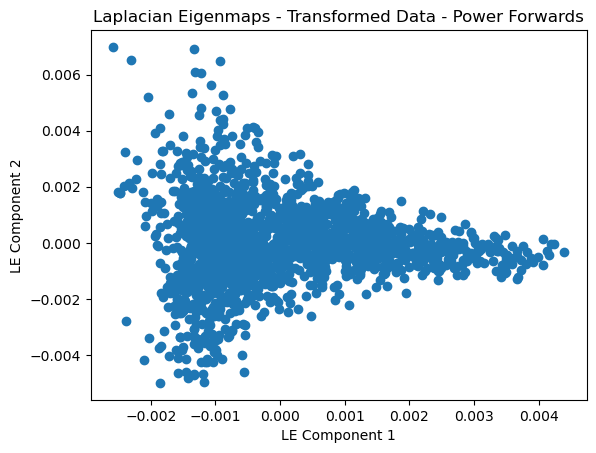

In [22]:
plt.scatter(transformed_data[:, 0], transformed_data[:, 1])
plt.title(f'Laplacian Eigenmaps - Transformed Data - Power Forwards')
plt.xlabel('LE Component 1')
plt.ylabel('LE Component 2')
plt.show()

In [23]:
from bokeh.models import ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.plotting import figure, show
from bokeh.models import Slider
from bokeh.layouts import column
from bokeh.io import show

In [24]:
# Creating a dataframe with the resulting LE components
le_plotted_df = pf_df.reset_index()
le_plotted_df['LE1'] = transformed_data[:, 0]
le_plotted_df['LE2'] = transformed_data[:, 1]

# Creating a ColumnDataSource for Bokeh
source = ColumnDataSource(le_plotted_df)

# Creating the figure for the bokeh plot
p = figure(
    title = 'LE Projection of Basketball Data - Power Forwards',
    x_axis_label = 'Component 1',
    y_axis_label = 'Component 2',
    width = 800,
    height = 600,
    tools = 'pan, wheel_zoom, box_zoom, reset, save'
)

# Define a color map based on the USG% values
mapper = linear_cmap(field_name='USG%', palette=Viridis256, low=le_plotted_df['USG%'].min(), high=le_plotted_df['USG%'].max())

# Scatter plot with color mapping
p.scatter(
    x = 'LE1',
    y = 'LE2',
    source = source,
    size = 10,
    alpha = 0.7,
    color=mapper,
    legend_label = 'Power Forwards'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Season', '@Season'),
    ('Player', '@Player'),
    ("USG%", "@{USG%}")
                 ]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title="USG%")
p.add_layout(color_bar, 'right')

show(p)

In [ ]:
# Creating a dataframe with the resulting LE components
le_plotted_df = pf_df.reset_index()
le_plotted_df['LE1'] = transformed_data[:, 0]
le_plotted_df['LE2'] = transformed_data[:, 1]

# Creating a ColumnDataSource for Bokeh
source = ColumnDataSource(le_plotted_df)

# Creating the figure for the bokeh plot
p = figure(
    title = 'LE Projection of Basketball Data - Power Forwards',
    x_axis_label = 'Component 1',
    y_axis_label = 'Component 2',
    width = 800,
    height = 600,
    tools = 'pan, wheel_zoom, box_zoom, reset, save'
)

# Define a color map based on the USG% values
mapper = linear_cmap(field_name='% of FGA by Distance - 3P', palette=Viridis256, low=le_plotted_df['% of FGA by Distance - 3P'].min(), high=le_plotted_df['% of FGA by Distance - 3P'].max())

# Scatter plot with color mapping
p.scatter(
    x = 'LE1',
    y = 'LE2',
    source = source,
    size = 10,
    alpha = 0.7,
    color=mapper,
    legend_label = 'Power Forwards'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Season', '@Season'),
    ('Player', '@Player'),
    ("3P FGA%", "@{% of FGA by Distance - 3P}")
                 ]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title="% of FGA from 3P")
p.add_layout(color_bar, 'right')

show(p)

In [ ]:
# Creating a dataframe with the resulting LE components
le_plotted_df = pf_df.reset_index()
le_plotted_df['LE1'] = transformed_data[:, 0]
le_plotted_df['LE2'] = transformed_data[:, 1]


# Creating a ColumnDataSource for Bokeh
source = ColumnDataSource(le_plotted_df)

# Creating the figure for the bokeh plot
p = figure(
    title = 'LE Projection of Basketball Data - Power Forwards',
    x_axis_label = 'Component 1',
    y_axis_label = 'Component 2',
    width = 800,
    height = 600,
    tools = 'pan, wheel_zoom, box_zoom, reset, save'
)

# Creating the scatter plot
p.scatter(
    x = 'LE1',
    y = 'LE2',
    source = source,
    size = 10,
    alpha = 0.7,
    color = 'blue',
    legend_label = 'Power Forwards'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Season', '@Season'),
    ('Player', '@Player'),
    ("USG%", "@{USG%}"),
    ("3P FGA%", "@{% of FGA by Distance - 3P}")
                 ]
p.add_tools(hover)

show(p)

In [ ]:
embedding.affinity_matrix_

In [ ]:
df_affinity = pd.DataFrame(embedding.affinity_matrix_, columns=[f"Point_{i}" for i in range(embedding.affinity_matrix_.shape[0])],
                           index=[f"Point_{i}" for i in range(embedding.affinity_matrix_.shape[0])])

In [ ]:
df_affinity

In [ ]:
for df in all_dfs:
    df.drop(columns = ['Dunks - %FGA', 'Personal Fouls Committed'], inplace=True)
    df['TRB'] = df['ORB'] + df['DRB']

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

    # Drop the two REB columns in favor of TRB
    condensed_scaled_df = scaled_df.drop(columns = ['ORB', 'DRB'])
    
    embedding = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')
    transformed_data = embedding.fit_transform(condensed_scaled_df)
    
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1])
    plt.title(f'Laplacian Eigenmaps - Transformed Data - {df.name}')
    plt.xlabel('LE Component 1')
    plt.ylabel('LE Component 2')
    plt.show()

In [ ]:
df = c_df

In [ ]:
df = pf_df

In [ ]:
df.drop(columns = ['Dunks - %FGA', 'Personal Fouls Committed'], inplace=True)
df['TRB'] = df['ORB'] + df['DRB']

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

# Drop the two REB columns in favor of TRB
condensed_scaled_df = scaled_df.drop(columns = ['ORB', 'DRB', "% of FG Ast'd - 3P", 'Corner 3s - %3PA'])
    
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(condensed_scaled_df)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.title('Centers t-SNE Projection - 16 Most Important Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()